###02. Neural network Classification

Refer -  https://www.learnpytorch.io/02_pytorch_classification/

1. Binary
2. Multiclass
3. Multilabel

## 1. Make classification data

In [1]:
import torch

print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))

CUDA available: True
GPU name: NVIDIA GeForce RTX 3050 Laptop GPU


In [2]:
import sklearn
from sklearn.datasets import make_circles

In [3]:
from numpy.random.mtrand import rand
# make 1000 samples
n_samples = 1000

# create circles
X, y = make_circles(n_samples,
                    noise=0.02,
                    random_state=42)

In [4]:
len(X), len(y)

(1000, 1000)

In [5]:
X[:5]

array([[ 0.76026594,  0.22387823],
       [-0.76722217,  0.1455425 ],
       [-0.80815854,  0.14894355],
       [-0.3760283 ,  0.70320906],
       [ 0.44051035, -0.89761737]])

In [6]:
y[:5]

array([1, 1, 1, 1, 0])

In [7]:
# make dataframe
import pandas as pd
circles = pd.DataFrame({"X1":X[:,0],
                        "X2":X[:,1],
                        "label":y})
circles.head()

,X1,X2,label
0,0.760266,0.223878,1
1,-0.767222,0.145542,1
2,-0.808159,0.148944,1
3,-0.376028,0.703209,1
4,0.440510,-0.897617,0


In [8]:
circles.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

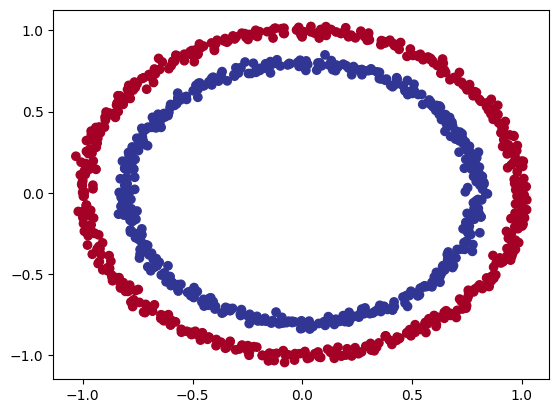

In [9]:
# visualize
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu)

**Note:** The data is often referred to as a ***toy data set***, (a problem that's used to try and test things out on) in machine learning.

## 1.1 input and output shape

In [10]:
X.shape, y.shape

((1000, 2), (1000,))

In [11]:
X[:3], y[:3]

(array([[ 0.76026594,  0.22387823],
        [-0.76722217,  0.1455425 ],
        [-0.80815854,  0.14894355]]),
 array([1, 1, 1]))

In [12]:
# View first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f"Sample: X: {X_sample} y: {y_sample}")
print(f"Shape: X: {X_sample.shape} y: {y_sample.shape}")

Sample: X: [0.76026594 0.22387823] y: 1
Shape: X: (2,) y: ()


### 1.2 Turn data into tensors and create train and test splits

In [13]:

import torch
torch.__version__

'2.5.1+cu121'

In [14]:
type(X), X.dtype, y.dtype

(numpy.ndarray, dtype('float64'), dtype('int64'))

In [15]:
# to tensor
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [16]:
type(X), X.dtype, y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [17]:
# split data to train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building a model

a model to classify **red** and **blue** dots

1. setup device agnostic code
2. construct the model by subclassing nn.module
3. define a loss function and optimizer
4. create a training and test loop

In [18]:
import torch
from torch import nn

# 1. device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

Device: cuda


1. subclasses `nn.Module`
2. create 2 `nn.linear()` - capable of handling shapes of data
3. defines a `forward()` method
4. instantiate an instance of model class and sent it to target device

In [19]:
X_train.shape

torch.Size([800, 2])

In [20]:
y_train[0]

tensor(1.)

In [21]:
# 1. construct model
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    # # 2. create 2 nn.Linear layers
    self.layer_1 = nn.Linear(in_features=2, out_features=5)# takes in 2 features (X), produces 5 features to learn(upscaling)
    self.layer_2 = nn.Linear(in_features=5, out_features=1)# takes in 5 features, produces 1 feature (y)
  # 3. forward method()
  def forward(self, x):
    return self.layer_2(self.layer_1(x)) #x->layer_1->layer_2

# 4. instantiate an instance
model_0 = CircleModelV0().to(device)
model_0


CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [22]:
device

'cuda'

In [23]:
# Replicate CircleModelV0 with nn.Sequential
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
    ).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [24]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.0304, -0.0983],
                      [ 0.6011, -0.1236],
                      [ 0.0541,  0.6599],
                      [ 0.3667, -0.2366],
                      [ 0.0918, -0.3089]], device='cuda:0')),
             ('0.bias',
              tensor([-0.6603,  0.2862, -0.1900,  0.3014, -0.6996], device='cuda:0')),
             ('1.weight',
              tensor([[-0.1561, -0.4286, -0.2211, -0.3720,  0.3038]], device='cuda:0')),
             ('1.bias', tensor([-0.1942], device='cuda:0'))])

In [25]:
# make predictions

with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))

print(f"Length of predictions: {len(untrained_preds)}, \nShape of predictions: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, \nShape of predictions: {X_test.shape}")
print(f"First 10 predictions: \n{untrained_preds[:10]}")
print(f"First 10 labels:\n{y[:10]}")

Length of predictions: 200, 
Shape of predictions: torch.Size([200, 1])
Length of test samples: 200, 
Shape of predictions: torch.Size([200, 2])
First 10 predictions: 
tensor([[-0.4076],
        [-0.5750],
        [-0.1973],
        [-0.4610],
        [-0.5936],
        [-0.6905],
        [-0.8663],
        [-0.8936],
        [-0.1845],
        [-0.6000]], device='cuda:0')
First 10 labels:
tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.])


###2.1 Setup loss function and optimizer

Ex: for regression - MAE/MSE, classification -crossentropy

Also, For example, the stochastic gradient descent optimizer (SGD, torch.optim.SGD()) can be used for a range of problems, and the same applies to the Adam optimizer (torch.optim.Adam()).

PyTorch has two binary cross entropy implementations:

1. torch.nn.BCELoss() - Creates a loss function that measures the binary cross entropy between the target (label) and input (features).
2. torch.nn.BCEWithLogitsLoss() - This is the same as above except it has a sigmoid layer (nn.Sigmoid) built-in (we'll see what this means soon).


In [26]:
# loss function
# loss_fn = nn.BCELoss() # BCELoss = no sigmoid built-in
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid built-in

# Create an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)


In [27]:
# calculate accuracy
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

## 3. Train model

* train loop

1. forward pass
2. calculate loss
3. optimizer zero_grad
4. loss backwards
5. optimizer step step

### 3.1 raw logits -> pred probs ->  pred labels

model outputs are going to be **raw digits**

conversion by passing them to some activation function


In [28]:
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [29]:
# view first 5 outputs of forward pass of test data
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.4076],
        [-0.5750],
        [-0.1973],
        [-0.4610],
        [-0.5936]], device='cuda:0')

In [30]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [31]:
# use sigmoid on model logits
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.3995],
        [0.3601],
        [0.4508],
        [0.3867],
        [0.3558]], device='cuda:0')

More specificially:

* If y_pred_probs >= 0.5, y=1 (class 1)
* If y_pred_probs < 0.5, y=0 (class 0)

In [32]:
# to get same format as y_test
torch.round(y_pred_probs)

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')

In [33]:
# find the predicted labels
y_preds = torch.round(y_pred_probs)

# in full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# check equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# get rid of extra dimensions
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 0., 0., 0., 0.], device='cuda:0')

###3.2 Building training and testing loop


* train loop

1. forward pass
2. calculate loss
3. optimizer zero_grad
4. loss backwards
5. optimizer step step

In [34]:
# manual seed
torch.manual_seed(42)

# set no: of epochs
epochs = 100

# put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
  model_0.train()

  # 1. forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) #turn logits->pred probs ->pred labels

  # 2. calculate loss/accuracy
  # loss = loss_fn(torch.sigmoid(y_logits), #nn.BCELoss ex[ects pred probs aas inputs
                #  y_train)
  loss = loss_fn(y_logits, #nn.BCEWithLogitsLoss expects raw logits as input
                 y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  # 3. optimizer zero grad
  optimizer.zero_grad()

  # 4. loss backward
  loss.backward()

  # 5. optimizer step
  optimizer.step()

  # Testing
  model_0.eval()
  with torch.inference_mode():
    # 1. forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. calculate test loss/accuracy
    test_loss = loss_fn(test_logits, #pred, true
                        y_test)
    test_acc = accuracy_fn(y_true=y_test, #true, pred
                           y_pred=test_pred)

# print results
    if epoch % 10 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f} | Accuracy: {acc:.2f} | Test loss: {test_loss:2f} | Test accuracy: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.73210 | Accuracy: 50.00 | Test loss: 0.722250 | Test accuracy: 50.00%
Epoch: 10 | Loss: 0.70829 | Accuracy: 43.75 | Test loss: 0.701514 | Test accuracy: 47.50%
Epoch: 20 | Loss: 0.70115 | Accuracy: 47.12 | Test loss: 0.695489 | Test accuracy: 51.50%
Epoch: 30 | Loss: 0.69865 | Accuracy: 48.12 | Test loss: 0.693571 | Test accuracy: 51.50%
Epoch: 40 | Loss: 0.69752 | Accuracy: 48.62 | Test loss: 0.692865 | Test accuracy: 51.50%
Epoch: 50 | Loss: 0.69684 | Accuracy: 49.12 | Test loss: 0.692551 | Test accuracy: 51.50%
Epoch: 60 | Loss: 0.69634 | Accuracy: 49.12 | Test loss: 0.692384 | Test accuracy: 50.50%
Epoch: 70 | Loss: 0.69595 | Accuracy: 49.50 | Test loss: 0.692286 | Test accuracy: 51.50%
Epoch: 80 | Loss: 0.69561 | Accuracy: 49.12 | Test loss: 0.692227 | Test accuracy: 51.50%
Epoch: 90 | Loss: 0.69533 | Accuracy: 49.38 | Test loss: 0.692196 | Test accuracy: 51.50%


## 4. Make predictions and evaluate model

* model isnt learning
* visualize


In [35]:
import requests
from pathlib import Path
# Download helper function from Learn Pytorch Repo
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skip dowloading")
else:
  print("Download helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

helper_functions.py already exists, skip dowloading


In [36]:
from helper_functions import plot_predictions, plot_decision_boundary

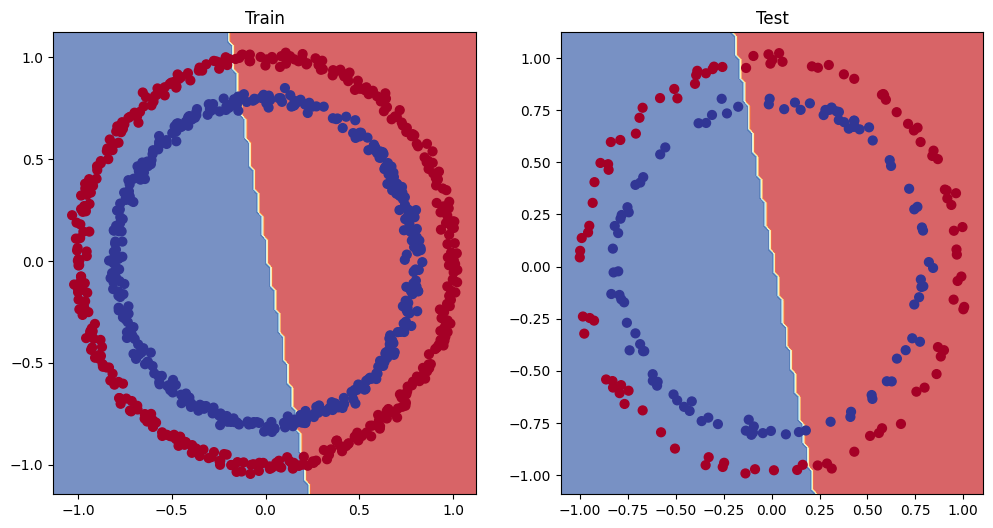

In [37]:
# plot decision boundary of model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)

plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving model (from model perspective)
* add more layers - more learning of patterns
* add more hidden units - from 5 to 10
* fit for longer
* changing the activation function
* change the lr (exploding gradient problem)
* change loss function

Therefore these are called **hyperparameters** since we can change it

* adding more hidden units 5->10
* more layers 2->3
* more epochs 100 ->1000

In [42]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10) #extra layer
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        
    def forward(self, x):
        # z = self.layer_1(x)
        # z = self.layer_2(z)
        # z = self.layer_3(z)
        # return z
        return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
model_1
        

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [43]:
model_1.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[-0.3041, -0.0775],
                      [-0.5293,  0.6441],
                      [-0.5190,  0.3779],
                      [ 0.2485,  0.2298],
                      [-0.3823,  0.6427],
                      [ 0.1554,  0.0910],
                      [-0.6231,  0.2968],
                      [-0.1061, -0.3239],
                      [ 0.6074,  0.1576],
                      [-0.3912, -0.3579]], device='cuda:0')),
             ('layer_1.bias',
              tensor([-0.0338,  0.3948, -0.1807, -0.4035, -0.2421, -0.5283,  0.2522,  0.5473,
                      -0.6657,  0.1642], device='cuda:0')),
             ('layer_2.weight',
              tensor([[ 0.1634,  0.0573, -0.1126,  0.1651,  0.1662,  0.1182, -0.0556, -0.0837,
                        0.0338, -0.0559],
                      [-0.0942,  0.2021,  0.2718, -0.0313, -0.0708,  0.0046, -0.0189,  0.0760,
                        0.0886, -0.2872],
                      [-0.1167,  0.266

In [ ]:
# create loss function
loss_fn = nn.BCEWithLogitsLoss()
# create optimizer
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)


In [45]:
# create a training and evaluation loop
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# train for longer
epochs = 1000

# put data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # training
    model_1.train()
    # 1.forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels
    # 2.calculate loss/acc
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true = y_train,
                        y_pred = y_pred)
    # 3.optimizer zero grad
    optimizer.zero_grad()
    # 4.loss backwards
    loss.backward()
    # 5.optimizer step
    optimizer.step()

    ###Testing
    model_1.eval()
    with torch.inference_mode():
        # 1.forward pass
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2.calculate loss
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test,
                                y_pred=test_pred)

    # print out everything happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}| Acc: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69526| Acc: 51.50% | Test Loss: 0.69259 | Test acc: 50.50%
Epoch: 100 | Loss: 0.69526| Acc: 51.50% | Test Loss: 0.69259 | Test acc: 50.50%
Epoch: 200 | Loss: 0.69526| Acc: 51.50% | Test Loss: 0.69259 | Test acc: 50.50%
Epoch: 300 | Loss: 0.69526| Acc: 51.50% | Test Loss: 0.69259 | Test acc: 50.50%
Epoch: 400 | Loss: 0.69526| Acc: 51.50% | Test Loss: 0.69259 | Test acc: 50.50%
Epoch: 500 | Loss: 0.69526| Acc: 51.50% | Test Loss: 0.69259 | Test acc: 50.50%
Epoch: 600 | Loss: 0.69526| Acc: 51.50% | Test Loss: 0.69259 | Test acc: 50.50%
Epoch: 700 | Loss: 0.69526| Acc: 51.50% | Test Loss: 0.69259 | Test acc: 50.50%
Epoch: 800 | Loss: 0.69526| Acc: 51.50% | Test Loss: 0.69259 | Test acc: 50.50%
Epoch: 900 | Loss: 0.69526| Acc: 51.50% | Test Loss: 0.69259 | Test acc: 50.50%


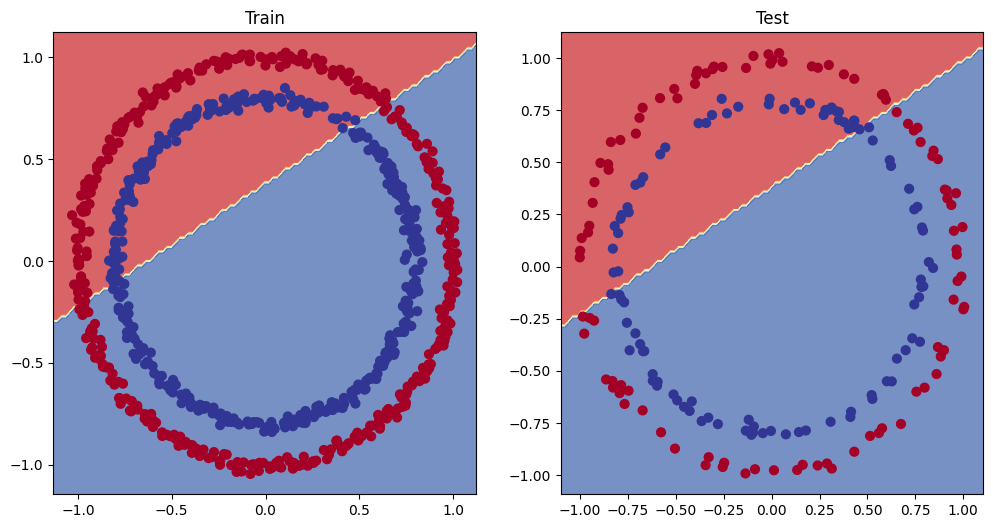

In [47]:
# plot decision boundary
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)

plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

## 5.1 Preparing data to see if our model can model a straight line
* from previous dataset from 01 pytorch workflow

In [48]:
# Create some data (same as notebook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias # linear regression formula

# Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [49]:
# Create train and test splits
train_split = int(0.8 * len(X_regression)) # 80% of data used for training set
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# Check the lengths of each split
print(len(X_train_regression), 
    len(y_train_regression), 
    len(X_test_regression), 
    len(y_test_regression))

80 80 20 20


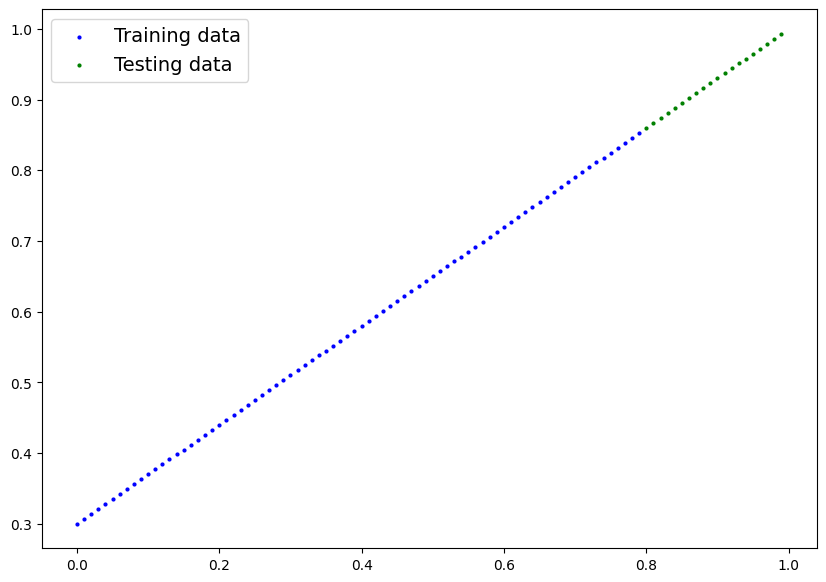

In [50]:
plot_predictions(train_data=X_train_regression,
    train_labels=y_train_regression,
    test_data=X_test_regression,
    test_labels=y_test_regression
);

In [51]:
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

### 5.2 Adjusting model_1 to fit a straight line

In [52]:
# Same architecture as model_1 (but using nn.Sequential)
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [53]:
# Loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.1)

In [58]:
# Train the model
torch.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data to target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

for epoch in range(epochs):
    ### Training 
    # 1. Forward pass
    y_pred = model_2(X_train_regression)
    
    # 2. Calculate loss (no accuracy since it's a regression problem, not classification)
    loss = loss_fn(y_pred, y_train_regression)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_2.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_pred = model_2(X_test_regression)
      # 2. Calculate the loss 
      test_loss = loss_fn(test_pred, y_test_regression)

    # Print out what's happening
    if epoch % 100 == 0: 
        print(f"Epoch: {epoch} | Train loss: {loss:.5f}, Test loss: {test_loss:.5f}")

Epoch: 0 | Train loss: 0.05256, Test loss: 0.00863
Epoch: 100 | Train loss: 0.04143, Test loss: 0.03835
Epoch: 200 | Train loss: 0.05512, Test loss: 0.01200
Epoch: 300 | Train loss: 0.04148, Test loss: 0.04377
Epoch: 400 | Train loss: 0.04762, Test loss: 0.02506
Epoch: 500 | Train loss: 0.06763, Test loss: 0.00993
Epoch: 600 | Train loss: 0.05564, Test loss: 0.04070
Epoch: 700 | Train loss: 0.05217, Test loss: 0.00599
Epoch: 800 | Train loss: 0.05460, Test loss: 0.00597
Epoch: 900 | Train loss: 0.06651, Test loss: 0.01789


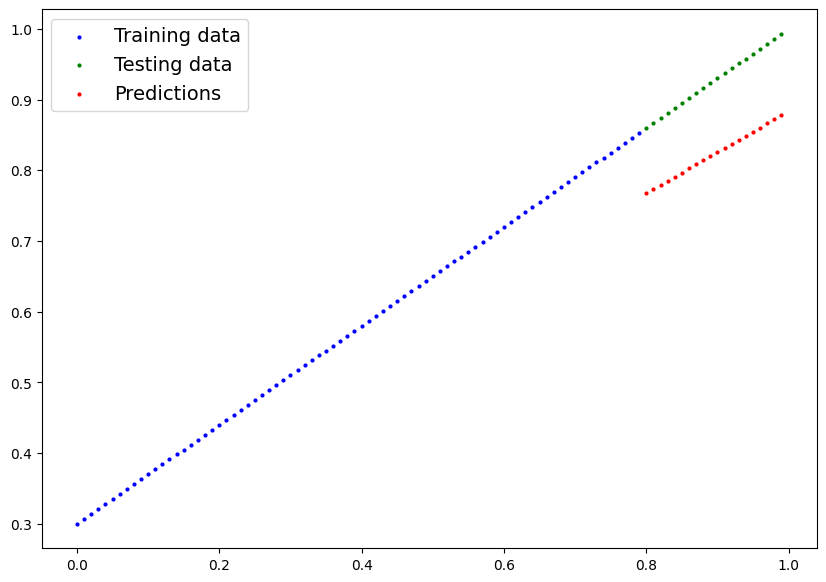

In [59]:
# Turn on evaluation mode
model_2.eval()

# Make predictions (inference)
with torch.inference_mode():
    y_preds = model_2(X_test_regression)

# Plot data and predictions with data on the CPU (matplotlib can't handle data on the GPU)
# (try removing .cpu() from one of the below and see what happens)
plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu());

## 6. The missing piece: non-linearity



### 6.1 Recreating non-linear data (red and blue circles)

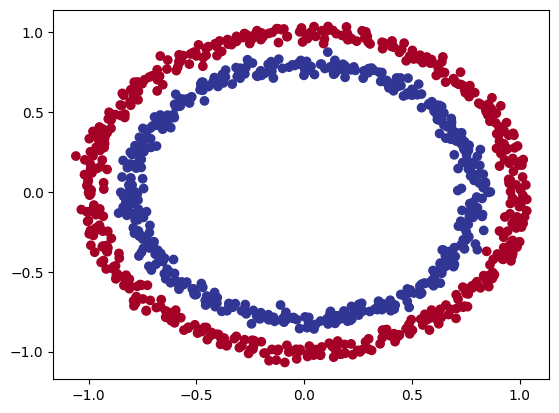

In [61]:
# make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.RdYlBu)

In [62]:
# convert to tensors and then to train and test splits
import torch
from sklearn.model_selection import train_test_split

# turn data to tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42)
X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

### 6.2 Building a model with non-linearity
* linear = straight line
* non-linear = non straight line
  

In [77]:
# Build a model with non-linear activation functions
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=20)
        self.layer_2 = nn.Linear(in_features=20, out_features=20)
        self.layer_3 = nn.Linear(in_features=20, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=20, bias=True)
  (layer_2): Linear(in_features=20, out_features=20, bias=True)
  (layer_3): Linear(in_features=20, out_features=1, bias=True)
  (relu): ReLU()
)

In [78]:
# loss function
loss_fn = nn.BCEWithLogitsLoss()
# optimizer
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

In [79]:
# training
torch.manual_seed(42)
torch.cuda.manual_seed(42)
epochs = 1000

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # train model
    model_3.train()
    # 1. forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels
    
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred)

    # 3. optimizer zero grad
    optimizer.zero_grad()

    # 4. loss backwards
    loss.backward()

    # 5. optimizer step
    optimizer.step()

    ###Testing
    model_3.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_3(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calculate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)
        
    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69448, Accuracy: 47.62% | Test Loss: 0.69197, Test Accuracy: 54.00%
Epoch: 100 | Loss: 0.69102, Accuracy: 53.12% | Test Loss: 0.68961, Test Accuracy: 56.50%
Epoch: 200 | Loss: 0.68750, Accuracy: 56.88% | Test Loss: 0.68704, Test Accuracy: 57.00%
Epoch: 300 | Loss: 0.68379, Accuracy: 59.62% | Test Loss: 0.68357, Test Accuracy: 59.50%
Epoch: 400 | Loss: 0.67821, Accuracy: 63.12% | Test Loss: 0.67807, Test Accuracy: 63.00%
Epoch: 500 | Loss: 0.66898, Accuracy: 69.50% | Test Loss: 0.66913, Test Accuracy: 72.00%
Epoch: 600 | Loss: 0.65292, Accuracy: 75.38% | Test Loss: 0.65433, Test Accuracy: 77.00%
Epoch: 700 | Loss: 0.62314, Accuracy: 85.62% | Test Loss: 0.62753, Test Accuracy: 84.00%
Epoch: 800 | Loss: 0.56539, Accuracy: 94.62% | Test Loss: 0.57623, Test Accuracy: 94.00%
Epoch: 900 | Loss: 0.45988, Accuracy: 99.38% | Test Loss: 0.48168, Test Accuracy: 98.00%


### 6.4 Evaluating a model trained with non-linear activation functions

In [80]:
# make predictions
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:5], y_test[:5]

(tensor([1., 0., 1., 0., 1.], device='cuda:0'),
 tensor([1., 0., 1., 0., 1.], device='cuda:0'))

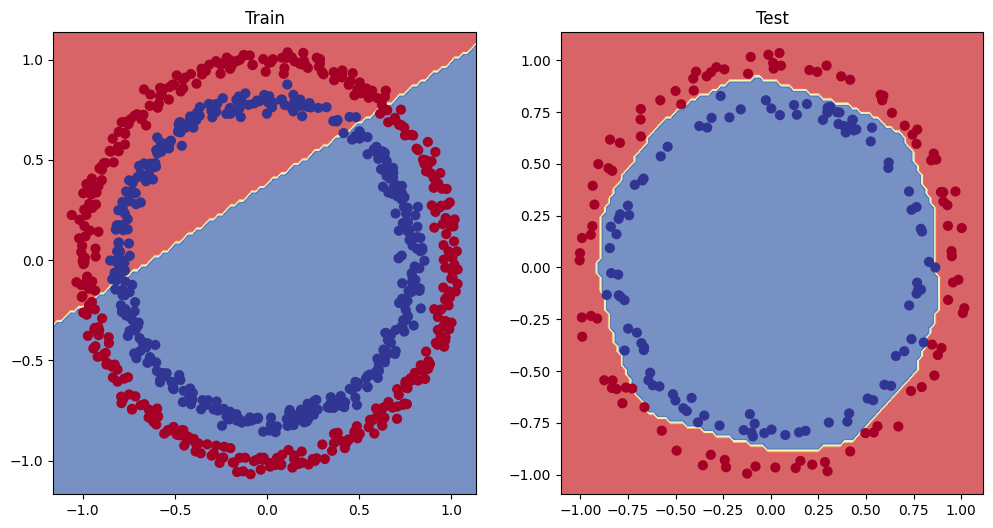

In [81]:
# plot decision boundary
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train) #model_1  = no non-linearity
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity

Got an accuracy of 98% after increasing the hidden units to 20 (past: 79% - 10)

## 7. Replicating non-linear activation functions

In [82]:
# Create a toy tensor (similar to the data going into our model(s))
A = torch.arange(-10, 10 , 1, dtype=torch.float32)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

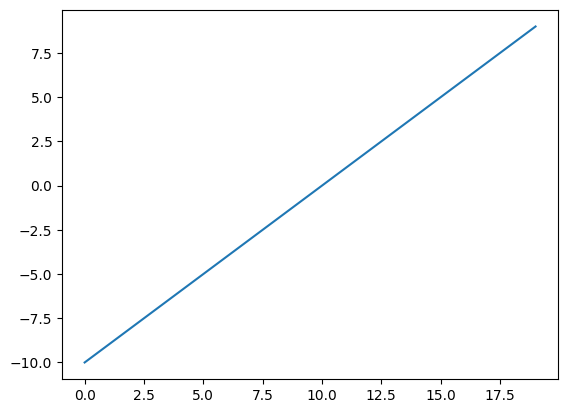

In [83]:
# Visualize the toy tensor
plt.plot(A);

And instead of using PyTorch's ReLU `(torch.nn.ReLU)`, we'll recreate it ourselves.

The ReLU function turns all negatives to 0 and leaves the positive values as they are.

In [84]:
def relu(x):
    return torch.maximum(torch.tensor(0), x) #input must be tensors

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

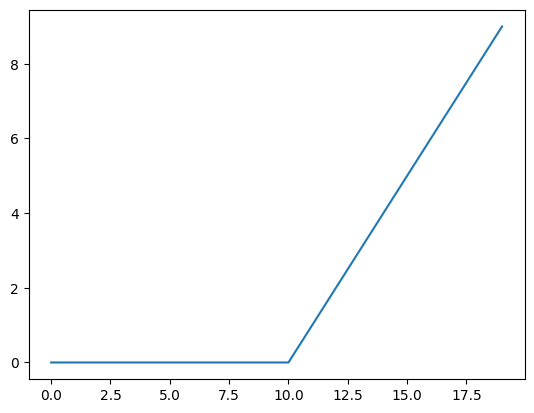

In [85]:
# Plot ReLU activated toy tensor
plt.plot(relu(A));

In [86]:
# Create a custom sigmoid function
def sigmoid(x):
  return 1 / (1 + torch.exp(-x))

# Test custom sigmoid on toy tensor
sigmoid(A)

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])

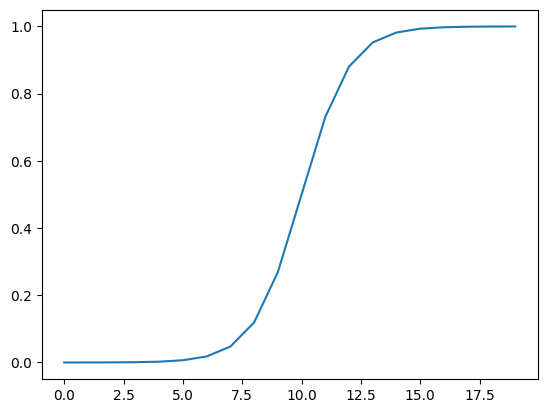

In [87]:
# Plot sigmoid activated toy tensor
plt.plot(sigmoid(A));

## 8. Putting things together by building a multi-class PyTorch model

* Binary classification = one or another
* Multi-class classification = more than one or another

### 8.1 Creating a toy multi-class classification data


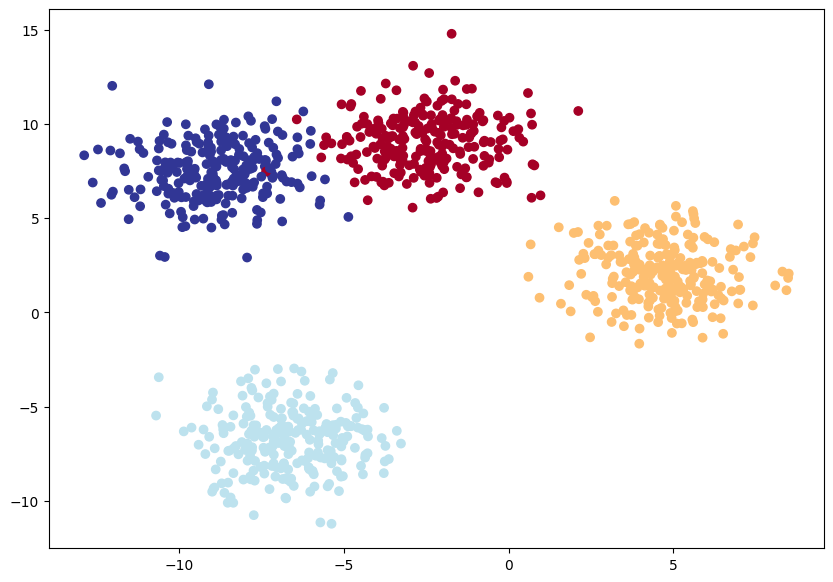

In [121]:
# importing
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs #https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html
from sklearn.model_selection import train_test_split

# set hyperparameters
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multiclass data
X_blob, y_blob = make_blobs(n_samples=1000,
                           n_features=NUM_FEATURES,
                           centers=NUM_CLASSES,
                           cluster_std=1.5, # give the clusters a little shake up
                           random_state=RANDOM_SEED)

# 2. turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor) #indices

#3. split to train and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                       y_blob,
                                                                       test_size=0.2,
                                                                       random_state=RANDOM_SEED)
# 4. Visualization
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:, 0],
           X_blob[:, 1],
           c=y_blob,
           cmap=plt.cm.RdYlBu)

### 8.2 Building a multiclass classification model in PyTorch


In [122]:
# create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [123]:
# build a multiclass model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_features)         
        )


    def forward(self, x):
        return self.linear_layer_stack(x)

# creating an instance
model_4 = BlobModel(input_features=NUM_FEATURES,
                   output_features=NUM_CLASSES,
                   hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [124]:
X_blob_train.shape, y_blob_train[:5]

(torch.Size([800, 2]), tensor([1, 0, 2, 2, 0]))

### 8.3 Create a loss function and optimizer

In [125]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(), lr=0.1)

In [126]:
# Perform a single forward pass on the data (we'll need to put it to the target device for it to work)
model_4(X_blob_train.to(device))[:5]

tensor([[-1.2711, -0.6494, -1.4740, -0.7044],
        [ 0.2210, -1.5439,  0.0420,  1.1531],
        [ 2.8698,  0.9143,  3.3169,  1.4027],
        [ 1.9576,  0.3125,  2.2244,  1.1324],
        [ 0.5458, -1.2381,  0.4441,  1.1804]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [127]:
# How many elements in a single prediction sample?
model_4(X_blob_train.to(device))[0].shape, NUM_CLASSES 

(torch.Size([4]), 4)

In [128]:
# Make prediction logits with model
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test.to(device))

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1) 
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-1.2549, -0.8112, -1.4795, -0.5696],
        [ 1.7168, -1.2270,  1.7367,  2.1010],
        [ 2.2400,  0.7714,  2.6020,  1.0107],
        [-0.7993, -0.3723, -0.9138, -0.5388],
        [-0.4332, -1.6117, -0.6891,  0.6852]], device='cuda:0')
tensor([[0.1872, 0.2918, 0.1495, 0.3715],
        [0.2824, 0.0149, 0.2881, 0.4147],
        [0.3380, 0.0778, 0.4854, 0.0989],
        [0.2118, 0.3246, 0.1889, 0.2748],
        [0.1945, 0.0598, 0.1506, 0.5951]], device='cuda:0')


In [129]:
# Sum the first sample output of the softmax activation function 
torch.sum(y_pred_probs[0])

tensor(1., device='cuda:0')

In [130]:
torch.max(y_pred_probs[0])

tensor(0.3715, device='cuda:0')

In [131]:
# Which class does the model think is *most* likely at the index 0 sample?
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.1872, 0.2918, 0.1495, 0.3715], device='cuda:0')
tensor(3, device='cuda:0')


In [132]:
# convert pred probs to pred labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds

tensor([3, 3, 2, 1, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2,
        2, 2, 3, 3, 3, 3, 3, 1, 1, 2, 1, 2, 1, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 3,
        3, 3, 1, 3, 3, 1, 3, 2, 3, 1, 3, 2, 2, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 3, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 3, 3, 2, 3, 3, 3, 3, 2, 3, 1, 3, 3, 2, 1, 1, 3, 2, 2, 3, 3, 3, 1, 2,
        2, 3, 3, 1, 2, 3, 3, 3, 2, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 1, 1, 3, 2, 2,
        2, 2, 3, 3, 3, 2, 2, 1, 3, 2, 3, 3, 3, 3, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3,
        2, 2, 2, 3, 3, 1, 1, 1, 1, 1, 3, 1, 3, 2, 2, 3, 2, 2, 3, 3, 2, 2, 3, 3,
        1, 3, 2, 3, 3, 1, 2, 3], device='cuda:0')

In [133]:
y_blob_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1])

## 8.5 Creating a training and testing loop for a multi-class PyTorch model

In [134]:
# Fit the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
epochs = 100

# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    ### Training
    model_4.train()

    # 1. Forward pass
    y_logits = model_4(X_blob_train) # model outputs raw logits 
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
    # print(y_logits)
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train)  
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_4.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_4(X_blob_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_blob_test)
      test_acc = accuracy_fn(y_true=y_blob_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%") 

Epoch: 0 | Loss: 1.04324, Acc: 65.50% | Test Loss: 0.57861, Test Acc: 95.50%
Epoch: 10 | Loss: 0.14398, Acc: 99.12% | Test Loss: 0.13037, Test Acc: 99.00%
Epoch: 20 | Loss: 0.08062, Acc: 99.12% | Test Loss: 0.07216, Test Acc: 99.50%
Epoch: 30 | Loss: 0.05924, Acc: 99.12% | Test Loss: 0.05133, Test Acc: 99.50%
Epoch: 40 | Loss: 0.04892, Acc: 99.00% | Test Loss: 0.04098, Test Acc: 99.50%
Epoch: 50 | Loss: 0.04295, Acc: 99.00% | Test Loss: 0.03486, Test Acc: 99.50%
Epoch: 60 | Loss: 0.03910, Acc: 99.00% | Test Loss: 0.03083, Test Acc: 99.50%
Epoch: 70 | Loss: 0.03643, Acc: 99.00% | Test Loss: 0.02799, Test Acc: 99.50%
Epoch: 80 | Loss: 0.03448, Acc: 99.00% | Test Loss: 0.02587, Test Acc: 99.50%
Epoch: 90 | Loss: 0.03300, Acc: 99.12% | Test Loss: 0.02423, Test Acc: 99.50%


### 8.6 Making and evaluating predictions with a PyTorch multi-class model

In [135]:
# make predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

y_logits[:10]

tensor([[  4.3377,  10.3539, -14.8948,  -9.7642],
        [  5.0142, -12.0371,   3.3860,  10.6699],
        [ -5.5885, -13.3448,  20.9894,  12.7711],
        [  1.8400,   7.5599,  -8.6016,  -6.9942],
        [  8.0726,   3.2906, -14.5998,  -3.6186],
        [  5.5844, -14.9521,   5.0168,  13.2890],
        [ -5.9739, -10.1913,  18.8655,   9.9179],
        [  7.0755,  -0.7601,  -9.5531,   0.1736],
        [ -5.5918, -18.5990,  25.5309,  17.5799],
        [  7.3142,   0.7197, -11.2017,  -1.2011]], device='cuda:0')

In [139]:
# from logits to pred probs
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:10]

tensor([[2.4332e-03, 9.9757e-01, 1.0804e-11, 1.8271e-09],
        [3.4828e-03, 1.3698e-10, 6.8363e-04, 9.9583e-01],
        [2.8657e-12, 1.2267e-15, 9.9973e-01, 2.6959e-04],
        [3.2692e-03, 9.9673e-01, 9.5436e-08, 4.7619e-07],
        [9.9168e-01, 8.3089e-03, 1.4120e-10, 8.2969e-06],
        [4.5039e-04, 5.4288e-13, 2.5532e-04, 9.9929e-01],
        [1.6306e-11, 2.4030e-13, 9.9987e-01, 1.3003e-04],
        [9.9860e-01, 3.9485e-04, 5.9938e-08, 1.0045e-03],
        [3.0436e-14, 6.8305e-20, 9.9965e-01, 3.5218e-04],
        [9.9843e-01, 1.3657e-03, 9.0768e-09, 2.0006e-04]], device='cuda:0')

In [146]:
# pred probs to pred labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds[:5], y_blob_test[:5]
print(f"Predictions: {y_preds[:5]} \nLabels: {y_blob_test[:5]}")
print(f"Accuracy:{accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0], device='cuda:0') 
Labels: tensor([1, 3, 2, 1, 0], device='cuda:0')
Accuracy:99.5%


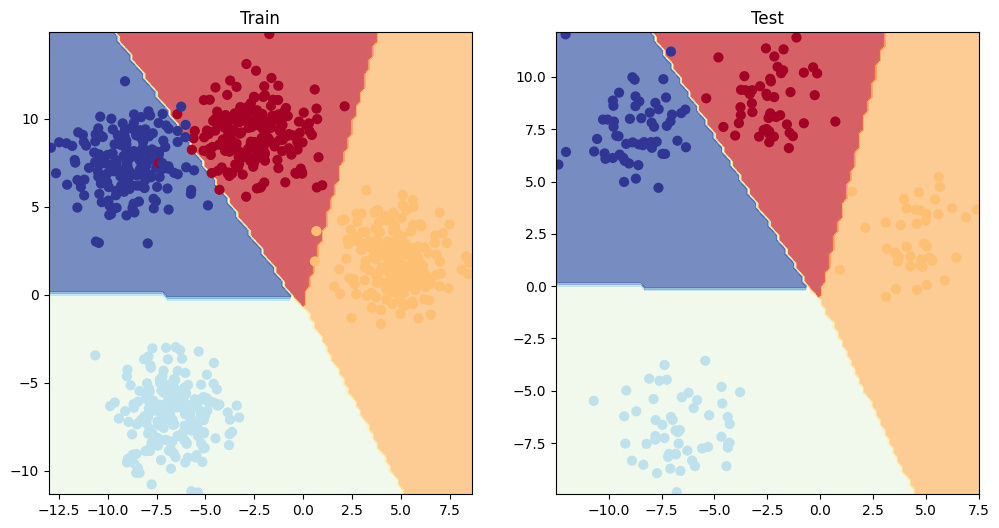

In [147]:
# visualize
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)